<p style="background-color:#368f8b;font-family:Trebuchet MS;font-weight:bold;color:#eff7f6;font-size:40px;text-align:center;border-radius:100px 100px">Table of Contents</p>

**In this notebook, we will cover:**
* [Overview](#0)
* [Exploratory Data Analysis](#1)
* [Recommender System](#2)
    1. [Hybrid Recommendation](#3)
    2. [Deep Learning (Tensorflow)](#4)

<a id=0 a/>
<p style="background-color:#368f8b;font-family:Trebuchet MS;font-weight:bold;color:#eff7f6;font-size:40px;text-align:center;border-radius:100px 100px">Overview</p>

<a id=1 a/>
<p style="background-color:#368f8b;font-family:Trebuchet MS;font-weight:bold;color:#eff7f6;font-size:40px;text-align:center;border-radius:100px 100px">Exploratory Data Analysis</p>

First thing first, there's always an EDA to give us a sense of what data we are dealing with. It's also useful to acquire some insights, informations, and even mistakes from data

In [ ]:
!pip install -q tensorflow-recommenders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 2.8 MB/s eta 0:00:00


In [ ]:
import string
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_recommenders as tfrs
from collections import Counter
from typing import Dict, Text
from ast import literal_eval
from datetime import datetime
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')

BY JENNIFER : I upload the files to colab, so I change the reading direction
(change whatever your way to read file)

In [ ]:
"""
credits = pd.read_csv('../input/the-movies-dataset/credits.csv')
keywords = pd.read_csv('../input/the-movies-dataset/keywords.csv')
movies = pd.read_csv('../input/the-movies-dataset/movies_metadata.csv').\
                    drop(['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'status', 'title', 'video'], axis=1).\
                    drop([19730, 29503, 35587]) # Incorrect data type
"""

credits = pd.read_csv('credits.csv')
keywords = pd.read_csv('keywords.csv')
movies = pd.read_csv('movies_metadata.csv').\
                    drop(['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'status', 'title', 'video'], axis=1).\
                    drop([19730, 29503, 35587]) # Incorrect data type


In [ ]:
"""
credits = pd.read_csv('/content/credits.csv')
keywords = pd.read_csv('/content/keywords.csv')
movies = pd.read_csv('/content/movies_metadata.csv').\
            drop(['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'status', 'title', 'video'], axis=1).\
            drop([19730, 29503, 35587]) # Incorrect data type
"""
movies['id'] = movies['id'].astype('int64')

# Merge the 'movies', 'keywords', and 'credits' DataFrames based on the 'id' column
df = movies.merge(keywords, on='id').\
    merge(credits, on='id')

# Fill NaN values in the 'original_language' column of 'df' with an empty string
df['original_language'] = df['original_language'].fillna('')
df['runtime'] = df['runtime'].fillna(0)
df['tagline'] = df['tagline'].fillna('')

# Drop rows containing NaN values in 'df'
df.dropna(inplace=True)

In [ ]:
# Define a function to extract text information from a column containing lists of dictionaries
def get_text(text, obj='name'):
    text = literal_eval(text)

    if len(text) == 1:
        for i in text:
            return i[obj]
    else:
        s = []
        for i in text:
            s.append(i[obj])
        return ', '.join(s)

# Apply the 'get_text' function to specific columns in the DataFrame 'df'
df['genres'] = df['genres'].apply(get_text)
df['production_companies'] = df['production_companies'].apply(get_text)
df['production_countries'] = df['production_countries'].apply(get_text)
df['crew'] = df['crew'].apply(get_text)
df['spoken_languages'] = df['spoken_languages'].apply(get_text)
df['keywords'] = df['keywords'].apply(get_text)

# New columns
# Create new columns using the 'get_text' function for the 'cast' column
df['characters'] = df['cast'].apply(get_text, obj='character')
df['actors'] = df['cast'].apply(get_text)

df.drop('cast', axis=1, inplace=True)

# Remove duplicate rows based on the 'original_title' column and reset the DataFrame index
df = df[~df['original_title'].duplicated()]
df = df.reset_index(drop=True)

In [ ]:
# Cleaned dataset
df.head()

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,...,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,keywords,crew,characters,actors
0,False,30000000,"Animation, Comedy, Family",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,Pixar Animation Studios,United States of America,...,373554033.0,81.0,English,,7.7,5415.0,"jealousy, toy, boy, friendship, friends, rival...","John Lasseter, Joss Whedon, Andrew Stanton, Jo...","Woody (voice), Buzz Lightyear (voice), Mr. Pot...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,..."
1,False,65000000,"Adventure, Fantasy, Family",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"TriStar Pictures, Teitler Film, Interscope Com...",United States of America,...,262797249.0,104.0,"English, Français",Roll the dice and unleash the excitement!,6.9,2413.0,"board game, disappearance, based on children's...","Larry J. Franco, Jonathan Hensleigh, James Hor...","Alan Parrish, Samuel Alan Parrish / Van Pelt, ...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ..."
2,False,0,"Romance, Comedy",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"Warner Bros., Lancaster Gate",United States of America,...,0.0,101.0,English,Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,"fishing, best friend, duringcreditsstinger, ol...","Howard Deutch, Mark Steven Johnson, Mark Steve...","Max Goldman, John Gustafson, Ariel Gustafson, ...","Walter Matthau, Jack Lemmon, Ann-Margret, Soph..."
3,False,16000000,"Comedy, Drama, Romance",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,Twentieth Century Fox Film Corporation,United States of America,...,81452156.0,127.0,English,Friends are the people who let you be yourself...,6.1,34.0,"based on novel, interracial relationship, sing...","Forest Whitaker, Ronald Bass, Ronald Bass, Ezr...","Savannah 'Vannah' Jackson, Bernadine 'Bernie' ...","Whitney Houston, Angela Bassett, Loretta Devin..."
4,False,0,Comedy,11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"Sandollar Productions, Touchstone Pictures",United States of America,...,76578911.0,106.0,English,Just When His World Is Back To Normal... He's ...,5.7,173.0,"baby, midlife crisis, confidence, aging, daugh...","Alan Silvestri, Elliot Davis, Nancy Meyers, Na...","George Banks, Nina Banks, Franck Eggelhoffer, ...","Steve Martin, Diane Keaton, Martin Short, Kimb..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42373 entries, 0 to 42372
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 42373 non-null  object 
 1   budget                42373 non-null  object 
 2   genres                42373 non-null  object 
 3   id                    42373 non-null  int64  
 4   original_language     42373 non-null  object 
 5   original_title        42373 non-null  object 
 6   overview              42373 non-null  object 
 7   popularity            42373 non-null  object 
 8   production_companies  42373 non-null  object 
 9   production_countries  42373 non-null  object 
 10  release_date          42373 non-null  object 
 11  revenue               42373 non-null  float64
 12  runtime               42373 non-null  float64
 13  spoken_languages      42373 non-null  object 
 14  tagline               42373 non-null  object 
 15  vote_average       

In [ ]:
df['release_date'] = pd.to_datetime(df['release_date'])
df['budget'] = df['budget'].astype('float64')
df['popularity'] = df['popularity'].astype('float64')

<h1 style="font-family: Trebuchet MS; font-size: 25px; color: #3a5a40; text-align: left; "><b>● Visualization 1</b></h1>

(0.0, 2.0, 0.9, 1.2)

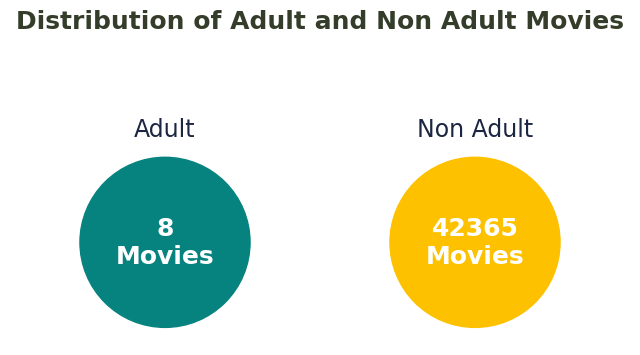

In [ ]:
plt.figure(figsize=(8,4))
plt.scatter(x=[0.5, 1.5], y=[1,1], s=15000, color=['#06837f', '#fdc100'])
plt.xlim(0,2)
plt.ylim(0.9,1.2)

plt.title('Distribution of Adult and Non Adult Movies', fontsize=18, weight=600, color='#333d29')
plt.text(0.5, 1, '{}\nMovies'.format(str(len(df[df['adult']=='True']))), va='center', ha='center', fontsize=18, weight=600, color='white')
plt.text(1.5, 1, '{}\nMovies'.format(str(len(df[df['adult']=='False']))), va='center', ha='center', fontsize=18, weight=600, color='white')
plt.text(0.5, 1.11, 'Adult', va='center', ha='center', fontsize=17, weight=500, color='#1c2541')
plt.text(1.5, 1.11, 'Non Adult', va='center', ha='center', fontsize=17, weight=500, color='#1c2541')

plt.axis('off')

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left; "><b>Insights:</b></h1>

* There is a huge difference between those 2 types of movies in terms of presence for this particular dataset

<h1 style="font-family: Trebuchet MS; font-size: 25px; color: #3a5a40; text-align: left; "><b>● Visualization 2</b></h1>

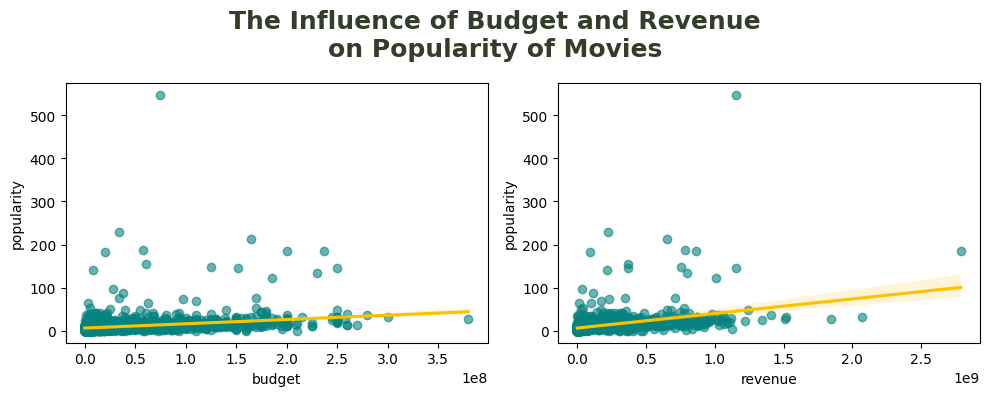

In [ ]:
df_plot = df[(df['budget'] != 0) & (df['revenue'] != 0)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

plt.suptitle('The Influence of Budget and Revenue\non Popularity of Movies', fontsize=18, weight=600, color='#333d29')
for i, col in enumerate(['budget', 'revenue']):
    sns.regplot(data=df_plot, x=col, y='popularity',
                scatter_kws={"color": "#06837f", "alpha": 0.6}, line_kws={"color": "#fdc100"}, ax=axes[i])

plt.tight_layout()

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left; "><b>Insights:</b></h1>

* Budget and Revenue just slighly influence the popularity of the movies

<h1 style="font-family: Trebuchet MS; font-size: 25px; color: #3a5a40; text-align: left; "><b>● Visualization 3</b></h1>

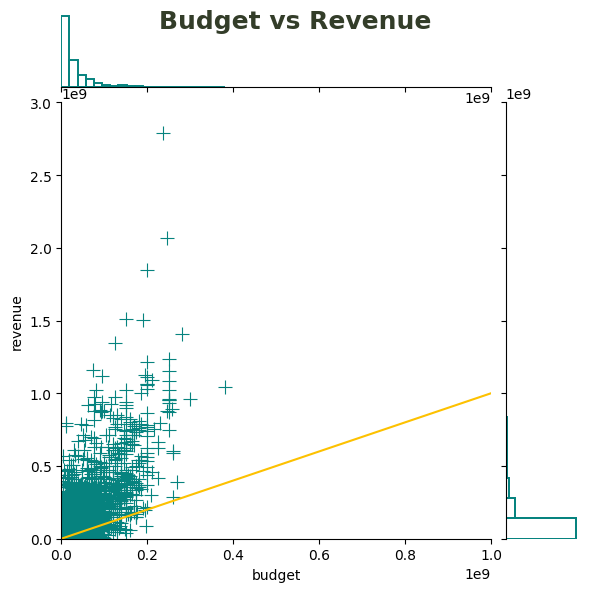

In [ ]:
ax = sns.jointplot(data=df[(df['budget'] != 0) & (df['revenue'] != 0)], x='budget', y='revenue',
                   marker="+", s=100, marginal_kws=dict(bins=20, fill=False), color='#06837f')
ax.fig.suptitle('Budget vs Revenue', fontsize=18, weight=600, color='#333d29')
ax.ax_joint.set_xlim(0, 1e9)
ax.ax_joint.set_ylim(0, 3e9)
ax.ax_joint.axline((1,1), slope=1, color='#fdc100')

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left; "><b>Insights:</b></h1>

* Most of the movies lay on top of the yellow line, indicate that those movies make a profit

<h1 style="font-family: Trebuchet MS; font-size: 25px; color: #3a5a40; text-align: left; "><b>● Visualization 4</b></h1>

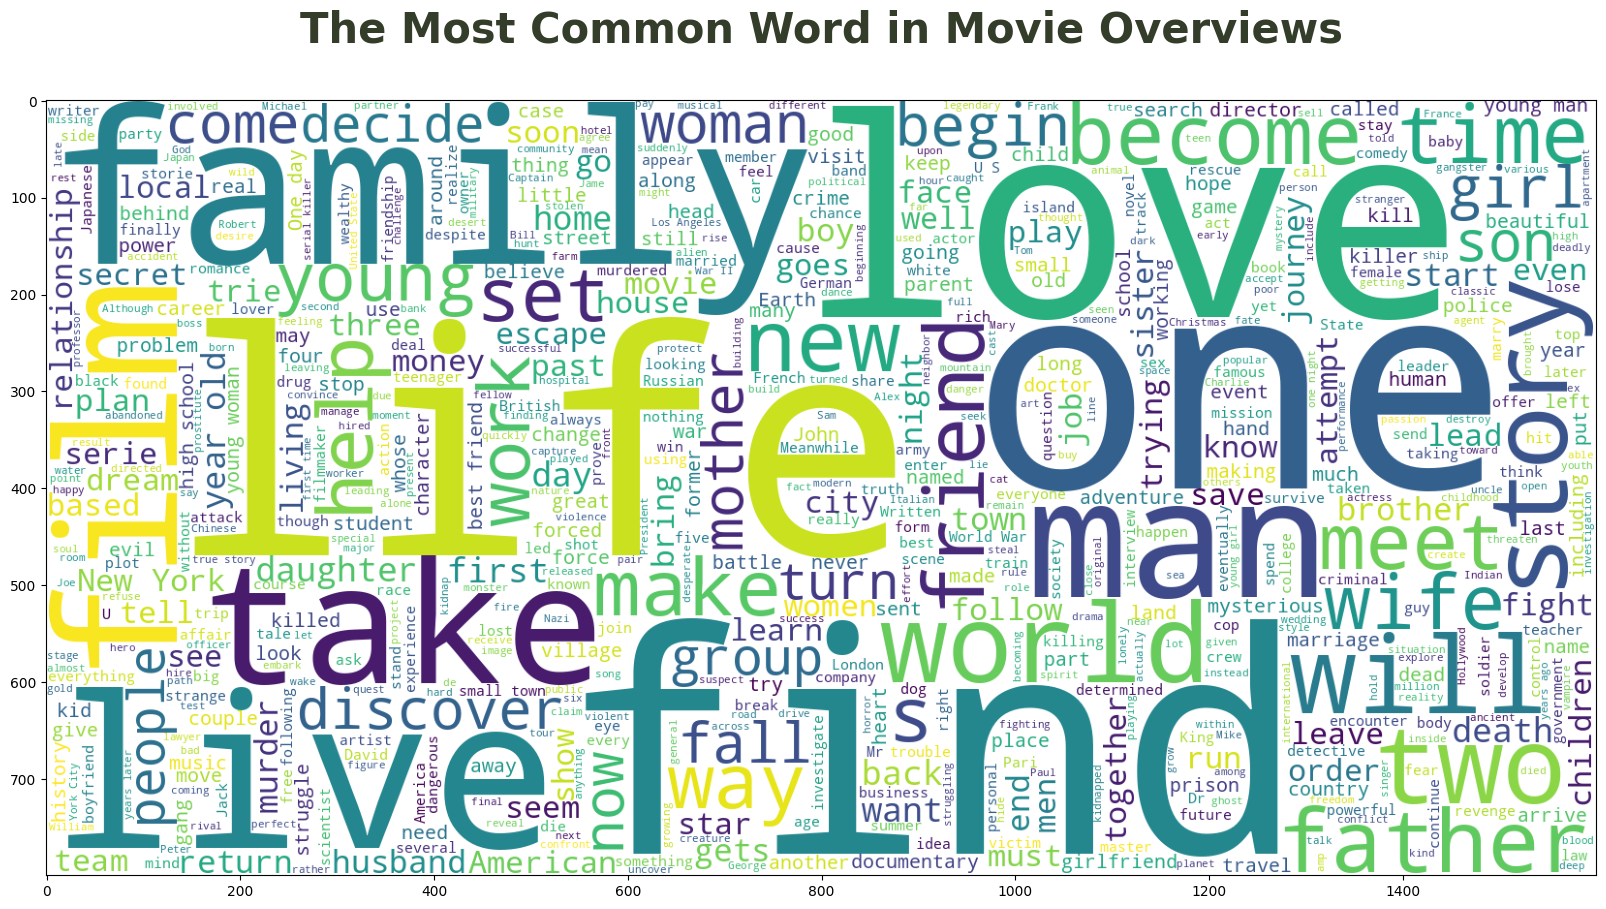

In [ ]:
plt.figure(figsize=(20,20))
plt.title('The Most Common Word in Movie Overviews\n', fontsize=30, weight=600, color='#333d29')
wc = WordCloud(max_words=1000, min_font_size=10,
                height=800,width=1600,background_color="white").generate(' '.join(df['overview']))

plt.imshow(wc)

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left; "><b>Insights:</b></h1>

* Word "life", "one", "find", "love" apparently appear in many occasions

<h1 style="font-family: Trebuchet MS; font-size: 25px; color: #3a5a40; text-align: left; "><b>● Visualization 5</b></h1>

(-1.25, 1.25, -1.25, 1.25)

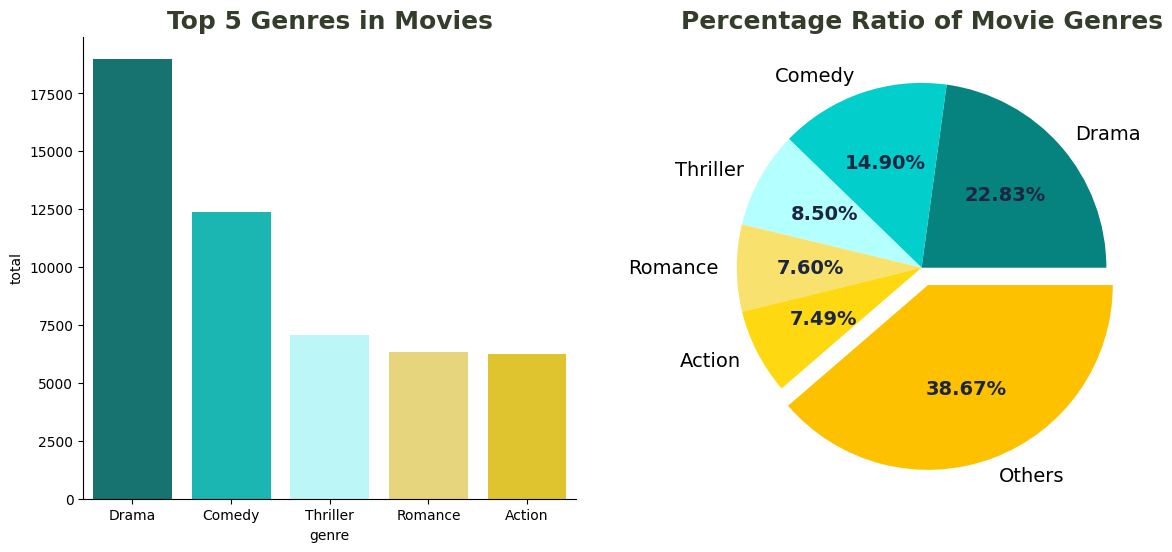

In [ ]:
genres_list = []
for i in df['genres']:
    genres_list.extend(i.split(', '))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

df_plot = pd.DataFrame(Counter(genres_list).most_common(5), columns=['genre', 'total'])
ax = sns.barplot(data=df_plot, x='genre', y='total', ax=axes[0], palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])
ax.set_title('Top 5 Genres in Movies', fontsize=18, weight=600, color='#333d29')
sns.despine()

df_plot_full = pd.DataFrame([Counter(genres_list)]).transpose().sort_values(by=0, ascending=False)
df_plot.loc[len(df_plot)] = {'genre': 'Others', 'total':df_plot_full[6:].sum()[0]}
plt.title('Percentage Ratio of Movie Genres', fontsize=18, weight=600, color='#333d29')
wedges, texts, autotexts = axes[1].pie(x=df_plot['total'], labels=df_plot['genre'], autopct='%.2f%%',
                                       textprops=dict(fontsize=14), explode=[0,0,0,0,0,0.1], colors=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811', '#fdc100'])

for autotext in autotexts:
    autotext.set_color('#1c2541')
    autotext.set_weight('bold')

axes[1].axis('off')

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left; "><b>Insights:</b></h1>

* Drama is the most dominant genre with over 18000 movies
* Out of 5 top genres, there are still many genres in the dataset. They hold 38.67% of total genres in the movies

<h1 style="font-family: Trebuchet MS; font-size: 25px; color: #3a5a40; text-align: left; "><b>● Visualization 6</b></h1>

Text(0.5, 1.0, 'Total Released Movie by Date')

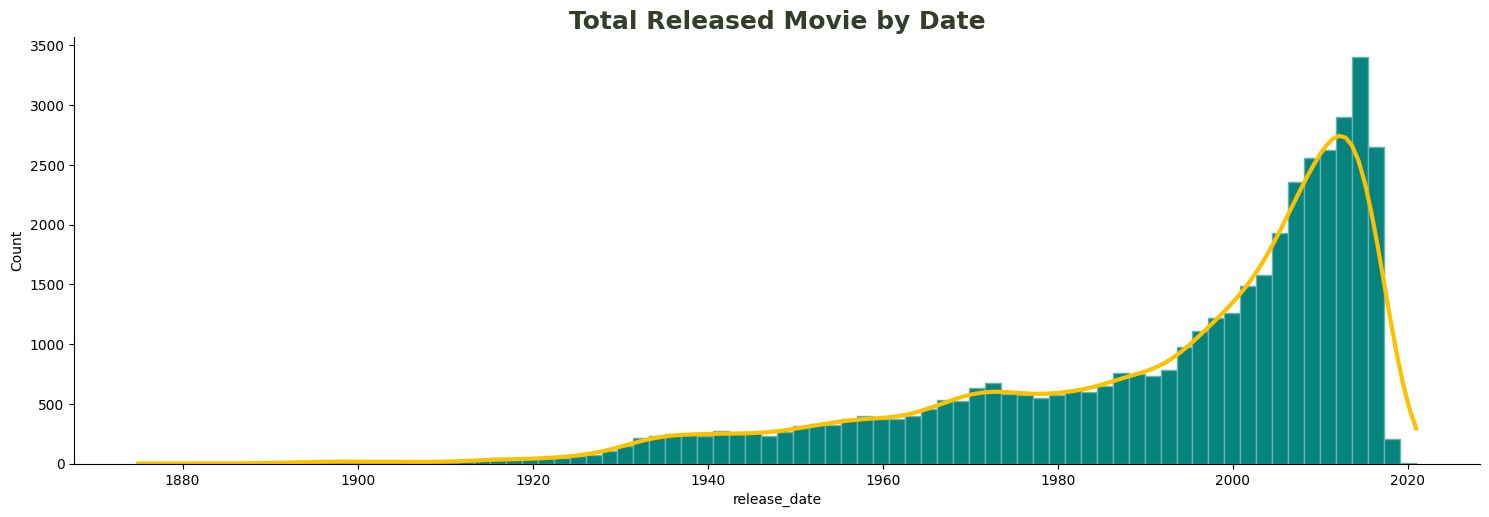

In [ ]:
sns.displot(data=df, x='release_date', kind='hist', kde=True,
            color='#fdc100', facecolor='#06837f', edgecolor='#64b6ac', line_kws={'lw': 3}, aspect=3)
plt.title('Total Released Movie by Date', fontsize=18, weight=600, color='#333d29')

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left; "><b>Insights:</b></h1>

* Started from 1930, movies industry had grown significantly from 50 years ago
* A drop in total released movies around 2020 is because the dataset only contains a few data in those years

<h1 style="font-family: Trebuchet MS; font-size: 25px; color: #3a5a40; text-align: left; "><b>● Visualization 7</b></h1>

In [ ]:
original_language_list = []
for i in df['original_language']:
    original_language_list.extend(i.split(', '))

spoken_languages_list = []
for i in df['spoken_languages']:
    if i != '':
        spoken_languages_list.extend(i.split(', '))

actors_list = []
for i in df['actors']:
    if i != '':
        actors_list.extend(i.split(', '))

crew_list = []
for i in df['crew']:
    if i != '':
        crew_list.extend(i.split(', '))

company_list = []
for i in df['production_companies']:
    if i != '':
        company_list.extend(i.split(', '))

country_list = []
for i in df['production_countries']:
    if i != '':
        country_list.extend(i.split(', '))

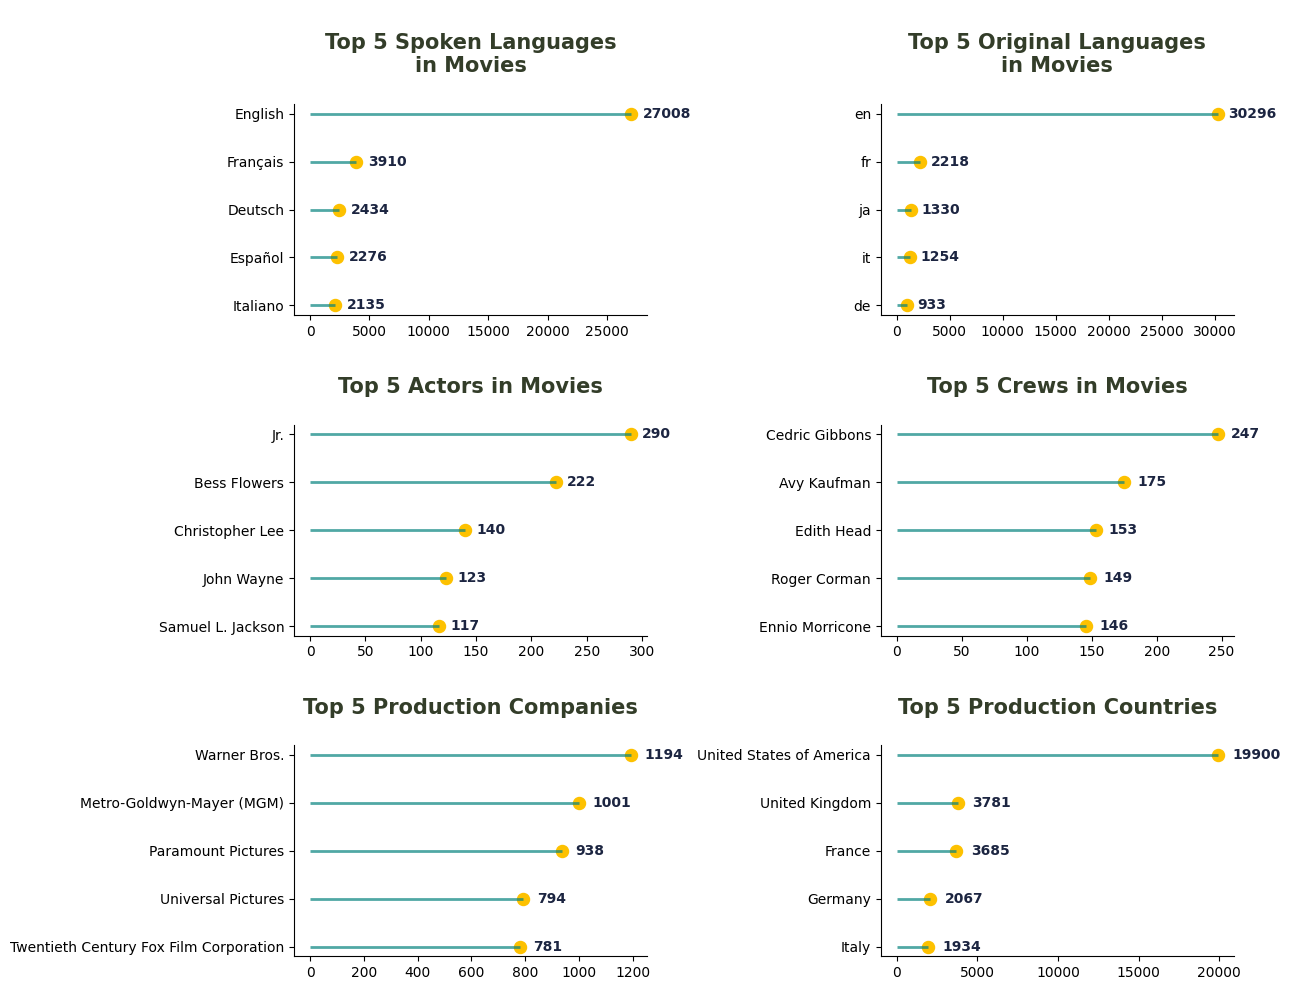

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(13, 10))

# Spoken language plot
df_plot1 = pd.DataFrame(Counter(spoken_languages_list).most_common(5), columns=['language', 'total']).sort_values(by='total', ascending=True)
axes[0,0].hlines(y=df_plot1['language'], xmin=0, xmax=df_plot1['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[0,0].scatter(x=df_plot1['total'], y=df_plot1['language'], s = 75, color='#fdc100')
axes[0,0].set_title('\nTop 5 Spoken Languages\nin Movies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot1['total']):
    axes[0,0].text(value+1000, i, value, va='center', fontsize=10, weight=600, color='#1c2541')

# Original Language plot
df_plot2 = pd.DataFrame(Counter(original_language_list).most_common(5), columns=['language', 'total']).sort_values(by='total', ascending=True)
axes[0,1].hlines(y=df_plot2['language'], xmin=0, xmax=df_plot2['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[0,1].scatter(x=df_plot2['total'], y=df_plot2['language'], s = 75, color='#fdc100')
axes[0,1].set_title('\nTop 5 Original Languages\nin Movies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot2['total']):
    axes[0,1].text(value+1000, i, value, va='center', fontsize=10, weight=600, color='#1c2541')

# Actor plot
df_plot3 = pd.DataFrame(Counter(actors_list).most_common(5), columns=['actor', 'total']).sort_values(by='total', ascending=True)
axes[1,0].hlines(y=df_plot3['actor'], xmin=0, xmax=df_plot3['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[1,0].scatter(x=df_plot3['total'], y=df_plot3['actor'], s = 75, color='#fdc100')
axes[1,0].set_title('\nTop 5 Actors in Movies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot3['total']):
    axes[1,0].text(value+10, i, value, va='center', fontsize=10, weight=600, color='#1c2541')

# Crew plot
df_plot4 = pd.DataFrame(Counter(crew_list).most_common(5), columns=['name', 'total']).sort_values(by='total', ascending=True)
axes[1,1].hlines(y=df_plot4['name'], xmin=0, xmax=df_plot4['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[1,1].scatter(x=df_plot4['total'], y=df_plot4['name'], s = 75, color='#fdc100')
axes[1,1].set_title('\nTop 5 Crews in Movies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot4['total']):
    axes[1,1].text(value+10, i, value, va='center', fontsize=10, weight=600, color='#1c2541')

# Company plot
df_plot5 = pd.DataFrame(Counter(company_list).most_common(5), columns=['name', 'total']).sort_values(by='total', ascending=True)
axes[2,0].hlines(y=df_plot5['name'], xmin=0, xmax=df_plot5['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[2,0].scatter(x=df_plot5['total'], y=df_plot5['name'], s = 75, color='#fdc100')
axes[2,0].set_title('\nTop 5 Production Companies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot5['total']):
    axes[2,0].text(value+50, i, value, va='center', fontsize=10, weight=600, color='#1c2541')

# Country plot
df_plot6 = pd.DataFrame(Counter(country_list).most_common(5), columns=['name', 'total']).sort_values(by='total', ascending=True)
axes[2,1].hlines(y=df_plot6['name'], xmin=0, xmax=df_plot6['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[2,1].scatter(x=df_plot6['total'], y=df_plot6['name'], s = 75, color='#fdc100')
axes[2,1].set_title('\nTop 5 Production Countries\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot6['total']):
    axes[2,1].text(value+900, i, value, va='center', fontsize=10, weight=600, color='#1c2541')

sns.despine()
plt.tight_layout()

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left; "><b>Insights:</b></h1>

* For this particular dataset, english is on top of the list for the original and spoken language in the movies
* Jr. and Cedric Gibbons are actor and crew involved in the most movies in the list respectively
* Warner Bros. with 1194 movies make it become top 1 production company in the list
* Many great production companies come from USA. So, it's not a surprise if USA is become our top 1 for production country

<h1 style="font-family: Trebuchet MS; font-size: 25px; color: #3a5a40; text-align: left; "><b>● Visualization 8</b></h1>

Text(0.5, 1.0, 'The Relationship Between Rating and Popularity')

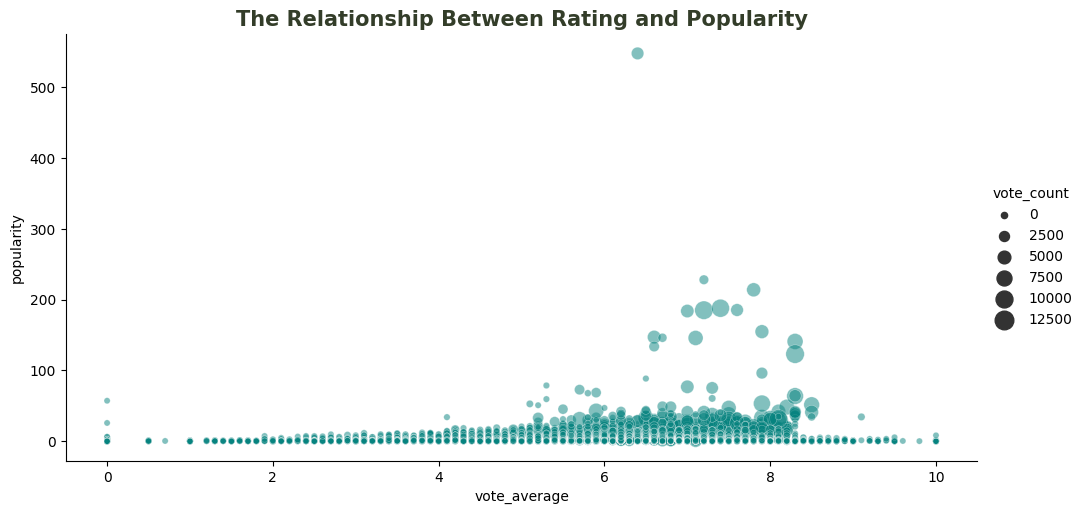

In [ ]:
sns.relplot(data=df, x='vote_average', y='popularity', size='vote_count',
            sizes=(20, 200), alpha=.5, aspect=2, color='#06837f')
plt.title('The Relationship Between Rating and Popularity', fontsize=15, weight=600, color='#333d29')

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left; "><b>Insights:</b></h1>

* Movies that either got rating 0 or 10 are basically caused by small number of voter. As the vote count increase, the rating is most likely around 5 to 8.5
* It's clear that popular movies will get more vote count as shown from above plot

<h1 style="font-family: Trebuchet MS; font-size: 25px; color: #3a5a40; text-align: left; "><b>● Visualization 9</b></h1>

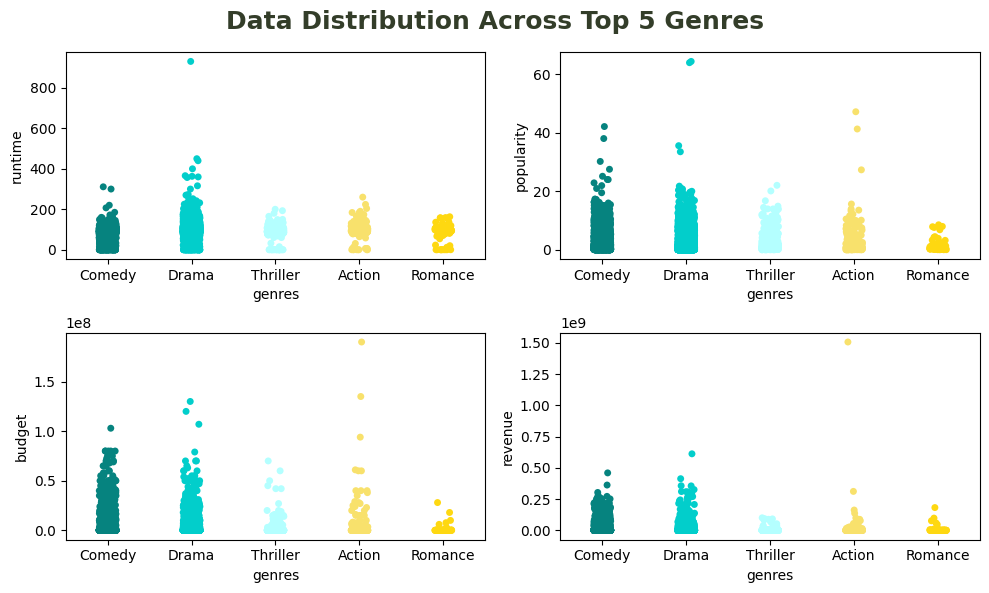

In [ ]:
df_plot = pd.DataFrame(Counter(genres_list).most_common(5), columns=['genre', 'total'])
df_plot = df[df['genres'].isin(df_plot['genre'].to_numpy())]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,6))

plt.suptitle('Data Distribution Across Top 5 Genres', fontsize=18, weight=600, color='#333d29')
for i, y in enumerate(['runtime', 'popularity', 'budget', 'revenue']):
    sns.stripplot(data=df_plot, x='genres', y=y, ax=axes.flatten()[i], palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])

plt.tight_layout()

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left; "><b>Insights:</b></h1>

* The movie genre that has the longest runtime is drama
* The least popular genre in the top 5 is romance
* Action movies spent more money than the rest of the movies
* One of the action movies got a vast profit compared to the others

<h1 style="font-family: Trebuchet MS; font-size: 25px; color: #3a5a40; text-align: left; "><b>● Visualization 10</b></h1>

<Axes: title={'center': 'Correlation of Movie Features\n'}>

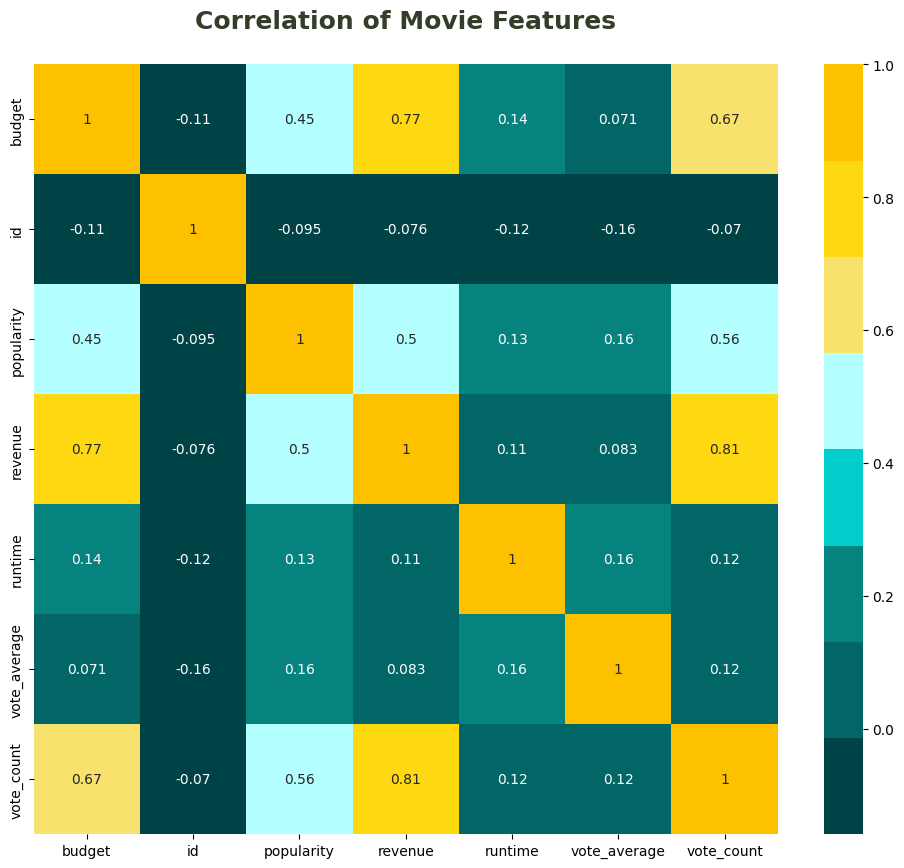

In [ ]:
plt.figure(figsize=(12,10))
plt.title('Correlation of Movie Features\n', fontsize=18, weight=600, color='#333d29')
sns.heatmap(df.corr(), annot=True, cmap=['#004346', '#036666', '#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811', '#fdc100'])

<h1 style="font-family: Trebuchet MS; font-size: 18px; color: #729b79; text-align: left; "><b>Insights:</b></h1>

* Vote count, budget, and popularity are 3 dominant features that will determined the revenue of the movies

<a id=2 a/>
<p style="background-color:#368f8b;font-family:Trebuchet MS;font-weight:bold;color:#eff7f6;font-size:40px;text-align:center;border-radius:100px 100px">Recommender System</p>

There are lots of methods that you can use to build recommender system. This time, we are going to explore two of them from which you can create build recommender system that can give an output of a recommended movies to the users based on different features

<a id=3 a/>
<h1 style="font-family: Trebuchet MS; font-size: 25px; color: #3a5a40; text-align: left; "><b>● Hybrid</b></h1>

For those of you who have been learning recommender system for a while, you might be familiar with weighted average. The idea behind it is to give a "fair" rating for each movie. For this particular notebook, we will take it to the next level with the help of bag of words

If you see the dataset we had, there are tons of valuable information such as genre, overview, etc. Later, we are going to use this information to make our recommender system more robust. we extract those information inside bag of words then combined it with weighted average to get the final similarity for the movies

![image.png](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/06/bayesianParameter.jpg.jpg)

Calculated weighted average scores for movies based on their average ratings and vote counts.

This approach helps consider both the **popularity and rating quality of movies.**

In [ ]:
R = df['vote_average']
v = df['vote_count']

# We will only consider movies that have more votes than at least 80% of the movies in our dataset
m = df['vote_count'].quantile(0.8)
C = df['vote_average'].mean()

df['weighted_average'] = (R*v + C*m)/(v+m)

In [ ]:
scaler = MinMaxScaler()

# Select columns for scaling ('popularity' and 'weighted_average') and transform them
scaled = scaler.fit_transform(df[['popularity', 'weighted_average']])

weighted_df = pd.DataFrame(scaled, columns=['popularity', 'weighted_average'])

weighted_df.index = df['original_title']

People watch a movie not just because they see a good rating for that movie, but also because of the hype of certain movie. So, in this case, put popularity into a consideration is a wise choice

Let's take **40% weight for weigthed average** and **60% weight for popularity** considering people don't want to miss a hype movie even the reviews and ratings are poor. You can play around with the number. Next up, we create a new column called score which stores the result

In [ ]:
weighted_df['score'] = weighted_df['weighted_average']*0.4 + weighted_df['popularity'].astype('float64')*0.6

In [ ]:
weighted_df_sorted = weighted_df.sort_values(by='score', ascending=False)
weighted_df_sorted.head(10)

,popularity,weighted_average,score
original_title,,,
Minions,1.000000,0.603532,0.841413
Big Hero 6,0.390602,0.827561,0.565386
Baby Driver,0.416507,0.727736,0.540998
Guardians of the Galaxy Vol. 2,0.338511,0.794867,0.521054
Pulp Fiction,0.257449,0.908395,0.517827
Deadpool,0.343132,0.764657,0.511742
Gone Girl,0.282748,0.843413,0.507014
The Dark Knight,0.224968,0.909123,0.498630
Avatar,0.338036,0.732643,0.495879


We already got the first result of our recommender system, but we don't stop right here

As mentioned earlier, **we will combine those score with the similarity score**

In [ ]:
hybrid_df = df[['original_title', 'adult', 'genres', 'overview', 'production_companies', 'tagline', 'keywords', 'crew', 'characters', 'actors']]

In [ ]:
def separate(text):
    clean_text = []
    for t in text.split(','):
        cleaned = re.sub('\(.*\)', '', t) # Remove text inside parentheses
        cleaned = cleaned.translate(str.maketrans('','', string.digits))
        cleaned = cleaned.replace(' ', '')
        cleaned = cleaned.translate(str.maketrans('','', string.punctuation)).lower()
        clean_text.append(cleaned)
    return ' '.join(clean_text)

def remove_punc(text):
    cleaned = text.translate(str.maketrans('','', string.punctuation)).lower()
    clean_text = cleaned.translate(str.maketrans('','', string.digits))
    return clean_text

In [ ]:
hybrid_df['adult'] = hybrid_df['adult'].apply(remove_punc)
hybrid_df['genres'] = hybrid_df['genres'].apply(remove_punc)
hybrid_df['overview'] = hybrid_df['overview'].apply(remove_punc)
hybrid_df['production_companies'] = hybrid_df['production_companies'].apply(separate)
hybrid_df['tagline'] = hybrid_df['tagline'].apply(remove_punc)
hybrid_df['keywords'] = hybrid_df['keywords'].apply(separate)
hybrid_df['crew'] = hybrid_df['crew'].apply(separate)
hybrid_df['characters'] = hybrid_df['characters'].apply(separate)
hybrid_df['actors'] = hybrid_df['actors'].apply(separate)

hybrid_df['bag_of_words'] = ''
hybrid_df['bag_of_words'] = hybrid_df[hybrid_df.columns[1:]].apply(lambda x: ' '.join(x), axis=1)
hybrid_df.set_index('original_title', inplace=True)

hybrid_df = hybrid_df[['bag_of_words']]
hybrid_df.head()

,bag_of_words
original_title,
Toy Story,false animation comedy family led by woody and...
Jumanji,false adventure fantasy family when siblings j...
Grumpier Old Men,false romance comedy a family wedding reignite...
Waiting to Exhale,false comedy drama romance cheated on mistreat...
Father of the Bride Part II,false comedy just when george banks has recove...


A common method to find similarity between 2 movies is a method called **cosine similarity**. There are of course a bunch of methods that you can try such as euclidean and sigmoidto know which one performs best

However, calculate similarity for all the movies require an expensive resources. So, because we have limited memory, we **only take the first 10000 movies from `weighted_df_sorted`**

In [ ]:
hybrid_df = weighted_df_sorted[:10000].merge(hybrid_df, left_index=True, right_index=True, how='left')

tfidf = TfidfVectorizer(stop_words='english', min_df=5)
tfidf_matrix = tfidf.fit_transform(hybrid_df['bag_of_words'])
tfidf_matrix.shape

(10000, 28645)

In [ ]:
cos_sim = cosine_similarity(tfidf_matrix)
cos_sim.shape

(10000, 10000)

In [ ]:
def predict(title, similarity_weight=0.7, top_n=10):
    data = hybrid_df.reset_index()
    index_movie = data[data['original_title'] == title].index
    similarity = cos_sim[index_movie].T

    sim_df = pd.DataFrame(similarity, columns=['similarity'])
    final_df = pd.concat([data, sim_df], axis=1)
    # You can also play around with the number
    final_df['final_score'] = final_df['score']*(1-similarity_weight) + final_df['similarity']*similarity_weight

    final_df_sorted = final_df.sort_values(by='final_score', ascending=False).head(top_n)
    final_df_sorted.set_index('original_title', inplace=True)
    return final_df_sorted[['score', 'similarity', 'final_score']]

In [ ]:
predict('Toy Story', similarity_weight=0.7, top_n=10)

,score,similarity,final_score
original_title,,,
Toy Story,0.348515,1.000000,0.804555
Toy Story 2,0.317785,0.537320,0.471460
Toy Story 3,0.336500,0.274778,0.293295
Toy Story of Terror!,0.282269,0.294860,0.291082
Small Fry,0.256223,0.271028,0.266586
Hawaiian Vacation,0.266277,0.263819,0.264556
Minions,0.841413,0.005376,0.256187
Finding Nemo,0.346185,0.203631,0.246397
WALL·E,0.348682,0.196733,0.242317


In [ ]:
# hybrid_df.to_csv('hybrid_df.csv')

In [ ]:
# import pickle
# pickle.dump(tfidf_matrix, open('cosine_similarity.pkl', 'wb'))

<a id=4 a/>
<h1 style="font-family: Trebuchet MS; font-size: 25px; color: #3a5a40; text-align: left; "><b>● Deep Learning</b></h1>

Official documentation: https://www.tensorflow.org/recommenders

Tensorflow comes with a library called **TensorFlow Recommenders (TFRS)** for building a recommender system. It's built on Keras and aims to have a gentle learning curve while still giving you the flexibility to build complex models.

This time, we use multi-objective approach that **applies both implicit (movie watches) and explicit signals (ratings)**. In the end, we can predict what movies should the user watch along **with the given rating corresponds to historical data**

In [ ]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

In [ ]:
import string
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
#import tensorflow_recommenders as tfrs
from collections import Counter
from typing import Dict, Text
from ast import literal_eval
from datetime import datetime
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')

In [ ]:
"""
import os
import pprint
import tempfile

from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import tensorflow_recommenders as tfrs

ratings = tfds.load('movielens/100k-ratings', split="train")
movies = tfds.load('movielens/100k-movies', split="train")

# Select the basic features.
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"],
})
movies = movies.map(lambda x: x["movie_title"])
"""

'\nimport os\nimport pprint\nimport tempfile\n\nfrom typing import Dict, Text\n\nimport numpy as np\nimport tensorflow as tf\nimport tensorflow_datasets as tfds\n\nimport tensorflow_recommenders as tfrs\n\nratings = tfds.load(\'movielens/100k-ratings\', split="train")\nmovies = tfds.load(\'movielens/100k-movies\', split="train")\n\n# Select the basic features.\nratings = ratings.map(lambda x: {\n    "movie_title": x["movie_title"],\n    "user_id": x["user_id"],\n    "user_rating": x["user_rating"],\n})\nmovies = movies.map(lambda x: x["movie_title"])\n'

In [ ]:
# convert timestamps into datetime format, merge two DataFrames
# filter out rows that do not have matching data, and reset the index in preparation for further analysis or processing.
ratings_df = pd.read_csv('/content/ratings.csv')


# Convert the 'timestamp' column to a 'date' column in datetime format
# Purpose: To transform the timestamp into a human-readable date for analysis.
ratings_df['date'] = ratings_df['timestamp'].apply(lambda x: datetime.fromtimestamp(x))
ratings_df.drop('timestamp', axis=1, inplace=True)

ratings_df = ratings_df.merge(df[['id', 'original_title', 'genres', 'overview']], left_on='movieId',right_on='id', how='left')
ratings_df = ratings_df[~ratings_df['id'].isna()]
ratings_df.drop('id', axis=1, inplace=True)
ratings_df.reset_index(drop=True, inplace=True)

ratings_df.head()

,userId,movieId,rating,date,original_title,genres,overview
0,1,110,1.0,2015-03-09 22:52:09,Trois couleurs : Rouge,"Drama, Mystery, Romance",Red This is the third film from the trilogy by...
1,1,147,4.5,2015-03-09 23:07:15,Les Quatre Cents Coups,Drama,"For young Parisian boy Antoine Doinel, life is..."
2,1,858,5.0,2015-03-09 22:52:03,Sleepless in Seattle,"Comedy, Drama, Romance",A young boy who tries to set his dad up on a d...
3,1,1246,5.0,2015-03-09 22:52:36,Rocky Balboa,Drama,When he loses a highly publicized virtual boxi...
4,1,1968,4.0,2015-03-09 23:02:28,Fools Rush In,"Drama, Comedy, Romance",Alex Whitman (Matthew Perry) is a designer fro...


In [ ]:
movies_df = df[['id', 'original_title']]
movies_df.rename(columns={'id':'movieId'}, inplace=True)
movies_df.head()

,movieId,original_title
0,862,Toy Story
1,8844,Jumanji
2,15602,Grumpier Old Men
3,31357,Waiting to Exhale
4,11862,Father of the Bride Part II


In [ ]:
# prepare data by organizing user IDs, movie titles, and ratings into TensorFlow datasets for subsequent model training
ratings_df['userId'] = ratings_df['userId'].astype(str)

# tf.data.Dataset.from_tensor_slices: we want to use tf.Dataset type, which is easier for training, so we transform ratings_df and movies_df into Dataset
ratings = tf.data.Dataset.from_tensor_slices(dict(ratings_df[['userId', 'original_title', 'rating']]))
movies = tf.data.Dataset.from_tensor_slices(dict(movies_df[['original_title']]))

ratings = ratings.map(lambda x: {
    "original_title": x["original_title"],
    "userId": x["userId"],
    "rating": float(x["rating"])
})

movies = movies.map(lambda x: x["original_title"])

In [ ]:
# split the data into a training set (train) and a test set (test) for model
# The shuffling and use of a random seed are important for ensuring that the data is randomly and consistently split for training and testing.
print('Total Data: {}'.format(len(ratings)))

# shuffle: Randomly shuffles the elements of this dataset.
# [1, 0, 2] -> [2, 1, 0]
# reshuffle_each_iteration= False means not to reshuffle after each iteration
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

# take: Creates a Dataset with at most count elements from this dataset.
# creates a training dataset train by taking the first 80,000 elements from the shuffled dataset
train = ratings.take(80_000)

# skip: Creates a Dataset that skips count elements from this dataset.
# taking the next 20,000 elements
test = ratings.skip(80_000).take(20_000)

Total Data: 10969295


In [ ]:
# batches movie titles and user IDs for efficient handling
# identifies the unique values of movies and users in the respective datasets (data preprocessing / feature engineering)

# batch: Combines consecutive elements of this dataset into batches.
# example : dataset = tf.data.Dataset.range(8)
#	dataset = dataset.batch(3)
# e.g. [ array([0,1,2]), array([3,4,5]), array([6,7]) ]
movie_titles = movies.batch(1_000)
user_ids = ratings.batch(1_000).map(lambda x: x["userId"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

print('Unique Movies: {}'.format(len(unique_movie_titles)))
print('Unique users: {}'.format(len(unique_user_ids)))

KeyboardInterrupt: ignored

This code defines a custom recommendation model using TensorFlow Recommenders (TFRS)

In [ ]:
# tfrs.models.Model: This base class makes it easy to define custom training and test losses for such complex models
class MovieModel(tfrs.models.Model):

  def __init__(self, rating_weight: float, retrieval_weight: float) -> None: # two weight parameters : rating_weight and retrieval_weight
    # Constructor method initializes the model.
    super().__init__() # Calls the constructor of the parent class (tfrs.models.Model) to initialize

    embedding_dimension = 64 # mapping high-dimensional discrete data to a lower-dimensional continuous vector space
                             # model can better capture their similarities and associations

    # User and movie models.
    # StringLookup : maps movie or user ids to integer indices ("vocabulary" to define the unique values )
    # Embedding : based on the integer indices obtained from the previous layer, maps the integer indices to lower-dimensional embedding vectors

    # tf.keras.layers.Layer: This is the class from which all layers inherit.
      # tf.keras.Sequential: groups a linear stack of layers into a tf.keras.Model.
      # tf.keras.layers.StringLookup: A preprocessing layer which maps string features to integer indices.
        #vocabulary=unique_movie_titles: applied to a unique set of movie titles
      #mask_token=None: no masking
      # tf.keras.layers.Embedding: Turns positive integers (indexes) into dense vectors of fixed size. #e.g. [[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]
        #len(unique_movie_titles) + 1 denotes the rows in the embedding matrix,
      #embedding_dimension signifies the dimensionality of the embedding vectors.
    self.movie_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])

    self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])


    # A small model to input user and movie embeddings and predict ratings
    # consists of three dense layers with activation functions, which are used to learn the relationships between user and movie embeddings.

    #tf.keras.Sequential: This function initializes a Sequential model, allowing the user to stack layers one after another in a sequence
      #tf.keras.layers.Dense(units = 256, activation=’relu’): This function creates a densely connected neural network layer
      #with 256 units/neurons and uses the ‘ReLU’ activation function.
      #tf.keras.layers.Dense(1): model's output. It's a regression-type model (as the output is a single value)
      #since there is no activation function specified for this layer, implying it would output continuous values directly.
    self.rating_model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(1),
    ])

    # Recommender systems are often composed of two components:
    # 1. a ranker model, scoring the candidates retrieved by the retrieval model to return a ranked shortlist of a few dozen candidates.
    # 2. a retrieval model, retrieving O(thousands) candidates from a corpus of O(millions) candidates.

    # Mean Squared Error (MSE) as the loss function and Root Mean Squared Error (RMSE) as a metric

    # tfrs.tasks.Ranking: designed for ranker models in recommendation systems.
    # It is used for training models to rank items or candidates according to their relevance or predicted scores.
      # loss: Loss function. Defaults to BinaryCrossentropy. tf.keras.losses.MeanSquaredError: Computes the mean of squares of errors between labels and predictions.
      # metrics: List of Keras metrics to be evaluated. tf.keras.metrics.RootMeanSquaredError: Computes root mean squared error metric between y_true and y_pred.
    self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )
    # tfrs.tasks.Retrieval: A factorized retrieval task.
      # metrics: Object for evaluating top-K metrics over a corpus of candidates. These metrics measure how good the model is at
      #picking the true candidate out of all possible candidates in the system
      # tfrs.metrics.FactorizedTopK: calculates the top K factorized metrics for the recommendations made by the retrieval model
        #movies.batch(128): making it easier to process large datasets in smaller chunks
        #map(self.movie_model): intended to transform movie data into embedding representations for retrieval purposes.
    self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies.batch(128).map(self.movie_model)
        )
    )

    # The loss weights.
    self.rating_weight = rating_weight
    self.retrieval_weight = retrieval_weight

  def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
    # Forward pass method to compute predictions.
    # Retrieve user embeddings based on the "userId" feature.

    user_embeddings = self.user_model(features["userId"])
    movie_embeddings = self.movie_model(features["original_title"])
    # These embedding vectors mean user and movie in a lower-dimensional continuous vector space.

    return (
        user_embeddings,
        movie_embeddings,
        self.rating_model(
            tf.concat([user_embeddings, movie_embeddings], axis=1) # put user and movie embeddings together
        ),  # takes the combined embedding vector as input, put them to NN layers
    )

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # Method to compute the loss during training.

    ratings = features.pop("rating")

    user_embeddings, movie_embeddings, rating_predictions = self(features)

    # Compute the loss for each task
    # real rating v.s. prediction rating
    rating_loss = self.rating_task(
        labels=ratings,
        predictions=rating_predictions,
    )
    retrieval_loss = self.retrieval_task(user_embeddings, movie_embeddings)

    # Combine losses using the specified weights.
    return (self.rating_weight * rating_loss
            + self.retrieval_weight * retrieval_loss)


In [ ]:
#compile(optimizer): This parameter configures the optimizer used during training.
	#tf.keras.optimizers.Adagrad(0.1): The model is compiled with the Adagrad optimizer, a learning rate of 0.1.
  #This configures the model for training by specifying the optimizer and its learning rate.
model = MovieModel(rating_weight=0.0, retrieval_weight=1.0)
#model = MovieModel(rating_weight=1.0, retrieval_weight=0.0)
#model = MovieModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

#cached_train = train.shuffle(100_000).batch(1_000).cache()
#cached_test = test.batch(1_000).cache()
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

model.fit(cached_train, epochs=3)

In [ ]:
metrics = model.evaluate(cached_train, return_dict=True)

print(f"\nRetrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}")

In [ ]:
#model.evaluate() is a method in TensorFlow used to evaluate the model on a given dataset.
	#cached_test represents the test dataset that was preprocessed and cached.
	#return_dict=True signifies that the evaluation results will be returned as a dictionary.
metrics = model.evaluate(cached_test, return_dict=True)

print(f"\nRetrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}")

In [ ]:
# model.save_weights('tfrs.h5')

In [ ]:
def predict_movie(user, top_n=3):
    # Create a model that takes in raw query features, and
    index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
    # recommends movies out of the entire movies dataset.
    # This index is used to perform nearest neighbor search in the embeddings space.


    #index_from_dataset(candidates): Builds the retrieval index. When called multiple times the existing index will be dropped and a new one created.
    #candidates  = Dataset of candidate embeddings or (candidate identifier, candidate embedding) pairs
      #tf.data.Dataset.zip(): Creates a Dataset by zipping together the given datasets.
        #movies.batch(100).map(model.movie_model: applies the model.movie_model (presumably an embedding model) to the movie dataset, mapping it to the corresponding embeddings.

    index.index_from_dataset(
      tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
    )

    # Get recommendations.
    #tf.constant: Creates a constant tensor from a tensor-like object.
    _, titles = index(tf.constant([str(user)]))

    print('Top {} recommendations for user {}:\n'.format(top_n, user))
    for i, title in enumerate(titles[0, :top_n].numpy()):
        print('{}. {}'.format(i+1, title.decode("utf-8")))

def predict_rating(user, movie):
    trained_movie_embeddings, trained_user_embeddings, predicted_rating = model({
          "userId": np.array([str(user)]),
          "original_title": np.array([movie])
      })
    print("Predicted rating for {}: {}".format(movie, predicted_rating.numpy()[0][0]))

In [ ]:
predict_movie(123, 5)

In [ ]:
predict_rating(123,'Minions')

In [ ]:
# r correlation
cached_test['rating']
cached_train['rating']

So, le't examine **User 123** from historical data

At a glance, we can see if **User 123** love watching Drama movies most of the time. He/She also gives a good rating for that genre. In our recommendation, We give 5 more Drama movies that we expect him/her to love the movies in a similar way with the previous watched movies.

In our dataset, we don't see any Animation movies that have been watched by **User 123**. So, it's not a surprise if the estimated rating for Minions is quite low